<a href="https://colab.research.google.com/github/Pythonash/Projects/blob/Brain/GAN%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20%EC%BB%AC%EB%9F%AC%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EA%B5%AC%ED%98%84%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 임포트

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Init Plugin
Init Graph Optimizer
Init Kernel


# cifar100 데이터셋 불러오기

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169009152/169001437 [==============================] - 27s 0us/step


# 이미지가 어떻게 생겼는지 보기

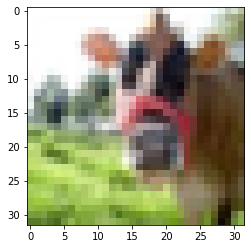

In [ ]:
plt.imshow(x_train[0])

# 데이터셋의 차원

각각 5만개, 1만개 그리고 넓이와 높이가 32이며 rgb 채널을 갖고 있음을 알 수 있다.

In [ ]:
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# 데이터셋 합쳐주기

훈련 시킬 데이터셋을 많이 확보하기 위해 다음과 같이 데이터셋을 합쳐준다.

In [ ]:
df = np.concatenate([x_train, x_test])
print(df.shape)

(60000, 32, 32, 3)


# 잘 합쳐졌는지 확인

테스트 데이터셋의 1번째 이미지

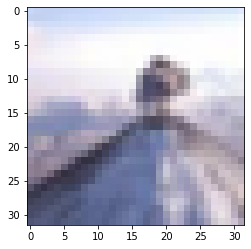

In [ ]:
plt.imshow(x_test[0])

합쳐진 데이터셋에서 테스트 데이터셋의 1번째에 해당하는 이미지

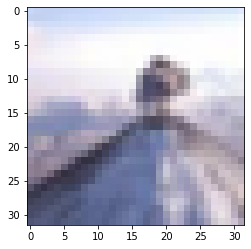

In [ ]:
plt.imshow(df[50000])

# 생성적 적대 신경망 구축하기

generator = 생성자

discriminator = 판별자

gan = 생성자와 판별자로 이루어진 gan 모델 구축

In [ ]:
size = 100

generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8 * 8 * 128, input_shape = [size]),
    tf.keras.layers.Reshape([8, 8, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size = 5, strides=2, padding='same', activation ='elu', kernel_initializer = 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(32, kernel_size = 5, strides=2, padding='same', activation = 'elu',kernel_initializer = 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2DTranspose(3, kernel_size = 5, strides=1, padding='same', activation = 'elu',kernel_initializer = 'he_normal')
])

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, kernel_size = 5, strides =2, padding='same', activation = tf.keras.layers.LeakyReLU(0.3),
                          input_shape=[32,32,3], kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, kernel_size = 5, strides=2, padding='same',
                          activation = tf.keras.layers.LeakyReLU(0.3), kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

gan = tf.keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 32, 32, 3)         1086787   
_________________________________________________________________
sequential_25 (Sequential)   (None, 1)                 911617    
Total params: 1,998,404
Trainable params: 1,964,932
Non-trainable params: 33,472
_________________________________________________________________


# 이미지 데이터셋 정규화해주기

In [ ]:
image = df/255

print(image.shape)

(60000, 32, 32, 3)


In [ ]:
print(image.max())
print(image.min())

1.0
0.0


# 이미지 데이터셋 스케일링

하이퍼볼릭 탄젠트 함수(-1과 1 사이의 값을 가짐)를 사용할 것이기 때문에 이와 같이 스케일링 해준다.

In [ ]:
image = image * 2. -1.
print(image.max())
print(image.min())

1.0
-1.0


# 데이터셋 적재

데이터셋을 배치로 꺼내 학습시켜주기 위해서 tensorflow 데이터셋을 사용한다.

In [ ]:
batch_size = 30
dataset = tf.data.Dataset.from_tensor_slices(image)
dataset = dataset.shuffle(2022)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

# 판별자 프리징

학습이 두 단계에 걸쳐 진행되는데, 판별자의 가중치를 다시 녹였다가 얼렸다가 반복해줄 것이기 때문에 먼저 판별자의 가중치를 얼려준다.

이때, 컴파일을 먼저해서 모델을 읽혀주고 가중치를 얼린다.

GAN 을 컴파일 하기전에 먼저 얼려줘야 하며, 생성자의 경우 따로 compile해주지 않는다.

 - GAN의 학습을 generator가 가중치를 업데이트하는데에 사용할 것이기 때문

In [ ]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False

# GAN 컴파일

In [ ]:
gan.compile(loss = 'binary_crossentropy', optimizer='rmsprop')

# 이미지를 나타내기 위한 함수 작성

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# 훈련 함수 작성

일반적인 fit과는 다르게 gan은 조금 다른 방식으로 훈련시켜줘야 한다.

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    for X_batch in dataset:
      noise = tf.random.normal(shape = [batch_size, codings_size])
      generated_images = generator(noise)
      generated_images = tf.cast(generated_images, tf.float64)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)

      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)
    maxx = np.array(generated_images).max()
    minn = np.array(generated_images).min()
    plot_multiple_images((np.array(generated_images) - minn) / (maxx-minn), 8)
    plt.show()

# 학습시작

에폭은 10으로 설정해본다.

Epoch 1/10


2022-02-07 23:17:46.598857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-07 23:17:47.013366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


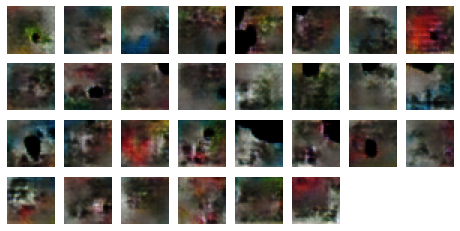

Epoch 2/10


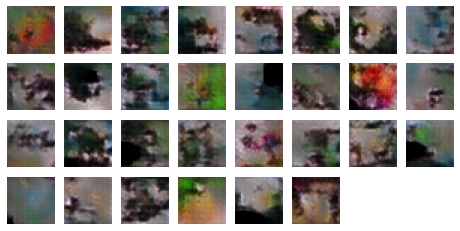

Epoch 3/10


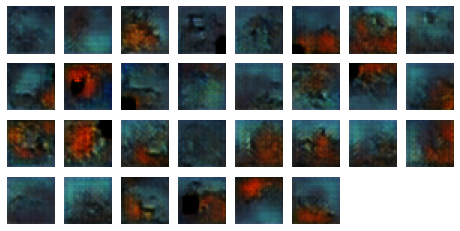

Epoch 4/10


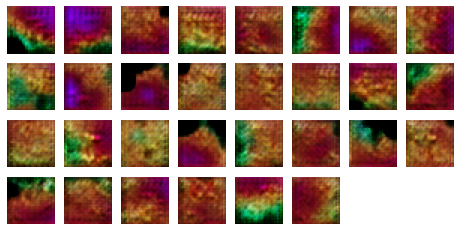

Epoch 5/10


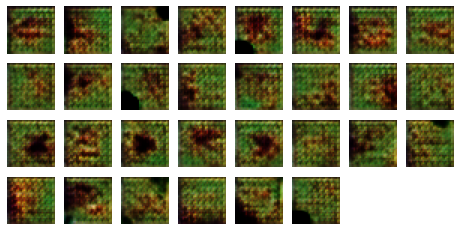

Epoch 6/10


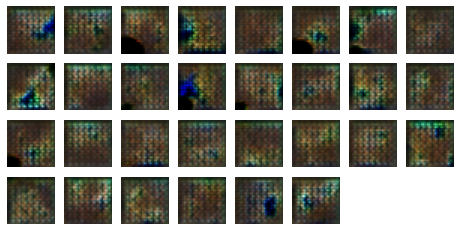

Epoch 7/10


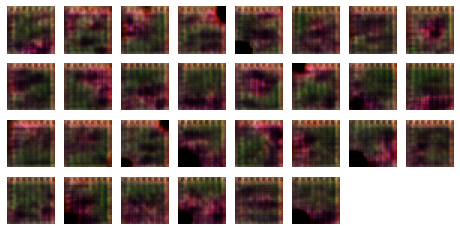

Epoch 8/10


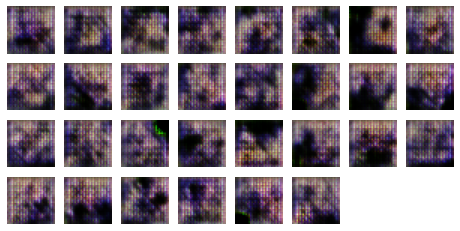

Epoch 9/10


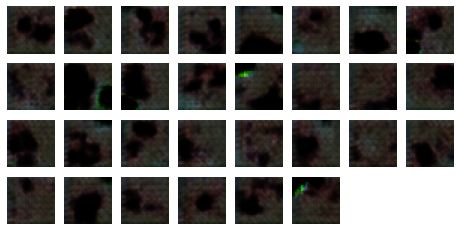

Epoch 10/10


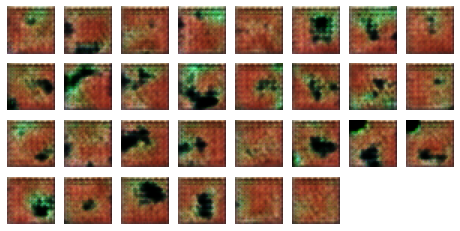

In [ ]:
train_gan(gan, dataset, batch_size, size, n_epochs=10)

# GAN이 만든 이미지

픽셀을 일단 0과 1사이 값으로 보정해주고 이미지를 출력해본다.

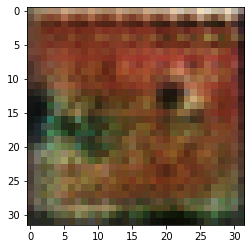

In [ ]:
maxx = np.array(generator(noise)).max()
minn = np.array(generator(noise)).min()


plt.imshow((((np.array(generator(noise)) - minn) ) / (maxx-minn))[0])

픽셀을 그대로 사용해서 이미지를 출력해본다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


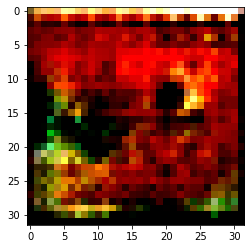

In [ ]:
plt.imshow(generator(noise)[0])

# References

- Geron, A. (2019). Hands on machine learning with scikit-learn and tensorflow 2nd.

- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., Bengio, Y. (2014). Generatvie Adversarial Nets, Advances in Neural Information Processing Systems 27 (NIPS 2014).